# Preparation

Package Importing

In [587]:
from Coursework.Codes.Deep_BSDE_Models import *
import matplotlib.pyplot as plt
import warnings
import pandas
warnings.filterwarnings('ignore')

The payoff function of the option the deep BSDE solver will simulate is
$$\begin{align}
H(S_T) = \max(\frac{1}{d}\sum_{i=1}^{d}S_T^i - K, 0)
\end{align}$$

Global Variables (1D)

In [588]:
IS_TRAINED = True
DEVICE = torch.device('cuda')
EPOCHS = 10000
ASSET_DIM = 1
LATENT_DIM = 10
TIME_TO_MATURITY = 1 / 12
NUM_INTERVAL = 10
TIME_EMBEDDING_DIM = 1
DT = TIME_TO_MATURITY / NUM_INTERVAL
BATCH_SIZE = 10 ** 4
RISK_FREE_RATE = 0.02
STRIKE = 99
KIND = "call"
COV = 0.01 * torch.eye(ASSET_DIM).to(DEVICE)
S0 = torch.ones(ASSET_DIM, device=DEVICE) * 100

## Training Set

In [589]:
torch.manual_seed(42)
T = torch.linspace(0, TIME_TO_MATURITY, NUM_INTERVAL + 1, device=DEVICE).repeat(BATCH_SIZE, 1).unsqueeze(-1)
dW, S = random_routes(
    S0_=S0,
    batch_size=BATCH_SIZE,
    time_to_maturity=TIME_TO_MATURITY,
    num_interval=NUM_INTERVAL,
    risk_free_rate=RISK_FREE_RATE,
    covariance=COV,
    device=DEVICE
)

In [590]:
monte_carlo_pricing(S, RISK_FREE_RATE, TIME_TO_MATURITY, payoff, STRIKE, KIND)

tensor(1.8544, device='cuda:0')

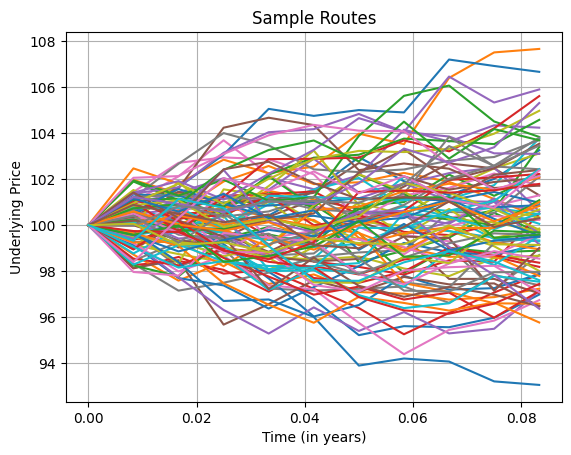

In [591]:
for route in S.cpu()[-100:]:
    plt.plot([t for t in T.cpu()[0]], route.mean(-1))
plt.grid()
plt.title("Sample Routes")
plt.xlabel("Time (in years)")
plt.ylabel("Underlying Price")
plt.show()

## Test Set

In [592]:
torch.manual_seed(42)
T_Test = torch.linspace(0, TIME_TO_MATURITY, 100 + 1, device=DEVICE).repeat(BATCH_SIZE, 1).unsqueeze(-1)
dW_Test, S_Test = random_routes(
    S0_=S0,
    batch_size=BATCH_SIZE,
    time_to_maturity=TIME_TO_MATURITY,
    num_interval=100,
    risk_free_rate=RISK_FREE_RATE,
    covariance=COV,
    device=DEVICE
)

# 1D Model Training

## Fully Connected Neural Network

In [593]:
Pure_FCNN_net = BSDE_Net(
    model=BSDE_FCNN,
    model_name=f"BSDE_PURE_FCNN_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=36,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=IS_TRAINED,
    device=DEVICE
)
print(f"Number of parameters in FCNN part: {Pure_FCNN_net.net.num_params}")

Number of parameters in FCNN part: 3146


### Training

In [594]:
if not Pure_FCNN_net.trained:
    training_bsde_solver(
        model=Pure_FCNN_net,
        model_name=Pure_FCNN_net.model_name,
        epochs=EPOCHS,
        dwt=dW,
        time_grid=T,
        risk_free_rate=RISK_FREE_RATE,
        cov_matrix=COV,
        price=S,
        payoff_=payoff,
        strike=STRIKE,
        kind=KIND,
        pinn_on=True,
        lr=1e-3,
        step_size=100,
        gamma=0.9,
        min_change=0.001
    )

### Evaluation

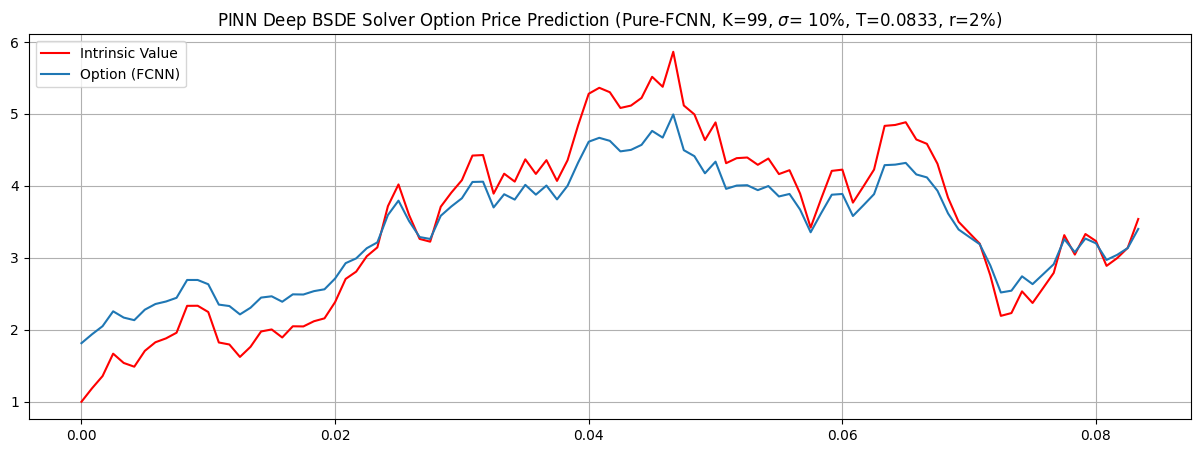

In [595]:
with torch.no_grad():
    Y_FCNN, Z_FCNN = Pure_FCNN_net(T_Test, S_Test)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(T_Test.cpu()[0], torch.relu(S_Test.cpu()[1].mean(-1) - STRIKE), color="red", label="Intrinsic Value")
ax.plot(T_Test.cpu()[0], Y_FCNN.cpu()[1], label="Option (FCNN)")
ax.grid()
ax.legend(loc="upper left")
plt.title(f"PINN Deep BSDE Solver Option Price Prediction (Pure-FCNN, K={STRIKE}, $\sigma$={COV[0][0] ** 0.5 * 100: .0f}%, T={TIME_TO_MATURITY:.4f}, r={RISK_FREE_RATE* 100:.0f}%)")
plt.show()

## Gated Recurrent Unit

In [596]:
GRU_net = BSDE_Net(
    model=BSDE_GRU,
    model_name=f"BSDE_GRU_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=28,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=False,
    device=DEVICE
)
print(f"Number of parameters in GRU part: {GRU_net.net.num_params}")

Number of parameters in GRU part: 2982


### Training

#### YNet Znet GRU Training (PINN-off)

In [597]:
if not IS_TRAINED:
    training_bsde_solver(
        model=GRU_net,
        model_name=GRU_net.model_name,
        epochs=EPOCHS,
        dwt=dW,
        time_grid=T,
        risk_free_rate=RISK_FREE_RATE,
        cov_matrix=COV,
        price=S,
        payoff_=payoff,
        strike=STRIKE,
        kind=KIND,
        pinn_on=False,
        lr=1e-2,
        step_size=100,
        gamma=0.1,
        save_params=False,
        min_change=0.001
)
    torch.save(GRU_net.YNet.state_dict(), f"./params/Best_BSDE_GRU_YNet_{ASSET_DIM}d.pth")
    torch.save(GRU_net.ZNet.state_dict(), f"./params/Best_BSDE_GRU_ZNet_{ASSET_DIM}d.pth")

In [598]:
GRU_FCNN_Net = BSDE_Net(
    model=BSDE_FCNN,
    model_name=f"BSDE_GRU_FCNN_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=36,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=IS_TRAINED,
    device=DEVICE
)
GRU_FCNN_Net.YNet.load_state_dict(torch.load(f"./params/Best_BSDE_GRU_YNet_{ASSET_DIM}d.pth"))
GRU_FCNN_Net.ZNet.load_state_dict(torch.load(f"./params/Best_BSDE_GRU_ZNet_{ASSET_DIM}d.pth"))

<All keys matched successfully>

#### PINN - ON

In [599]:
if not IS_TRAINED:
    # Freeze YNet and ZNet until the loss converges
    for param in GRU_FCNN_Net.YNet.parameters():
        param.requires_grad_(False)
    for param in GRU_FCNN_Net.ZNet.parameters():
        param.requires_grad_(False)
    losses = training_bsde_solver(
            model=GRU_FCNN_Net,
            model_name=GRU_FCNN_Net.model_name,
            epochs=EPOCHS,
            dwt=dW,
            time_grid=T,
            risk_free_rate=RISK_FREE_RATE,
            cov_matrix=COV,
            price=S,
            payoff_=payoff,
            strike=STRIKE,
            kind=KIND,
            pinn_on=True,
            lr=1e-3,
            step_size=100,
            gamma=0.9,
         min_change=0.001
    )

    torch.save(GRU_FCNN_Net.YNet.state_dict(), f"./params/Best_BSDE_GRU_YNet_{ASSET_DIM}d.pth")
    torch.save(GRU_FCNN_Net.ZNet.state_dict(), f"./params/Best_BSDE_GRU_ZNet_{ASSET_DIM}d.pth")

### Evaluation

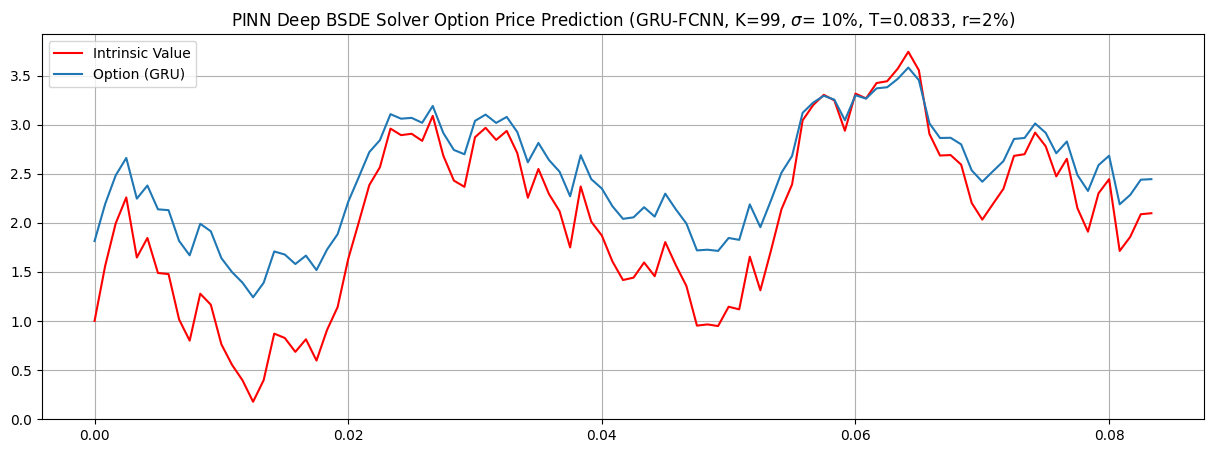

In [600]:
with torch.no_grad():
    Y_GRU, Z_GRU = GRU_FCNN_Net(T_Test, S_Test)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(T_Test.cpu()[0], torch.relu(S_Test.cpu()[0].mean(-1) - STRIKE), color="red", label="Intrinsic Value")
ax.plot(T_Test.cpu()[0], Y_GRU.cpu()[0], label="Option (GRU)")
ax.grid()
ax.legend(loc="upper left")

plt.title(f"PINN Deep BSDE Solver Option Price Prediction (GRU-FCNN, K={STRIKE}, $\sigma$={COV[0][0] ** 0.5 * 100: .0f}%, T={TIME_TO_MATURITY:.4f}, r={RISK_FREE_RATE* 100:.0f}%)")
plt.show()

## Recurrent Neural Network

In [601]:
RNN_net = BSDE_Net(
    model=BSDE_RNN,
    model_name=f"BSDE_RNN_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=30,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=False,
    device=DEVICE
)
print(f"Number of parameters in RNN part: {RNN_net.net.num_params}")

Number of parameters in RNN part: 3194


### Training


#### YNet ZNet RNN Training PINN-off

In [602]:
if not IS_TRAINED:
    losses = training_bsde_solver(
    model=RNN_net,
    model_name=RNN_net.model_name,
    epochs=EPOCHS,
    dwt=dW,
    time_grid=T,
    risk_free_rate=RISK_FREE_RATE,
    cov_matrix=COV,
    price=S,
    payoff_=payoff,
    strike=STRIKE,
    kind=KIND,
    pinn_on=IS_TRAINED,
    lr=1e-2,
    step_size=100,
    gamma=0.1,
    save_params=False
    )
    torch.save(RNN_net.YNet.state_dict(), f"./params/Best_BSDE_RNN_YNet_{ASSET_DIM}d.pth")
    torch.save(RNN_net.ZNet.state_dict(), f"./params/Best_BSDE_RNN_ZNet_{ASSET_DIM}d.pth")

In [603]:
RNN_FCNN_Net = BSDE_Net(
    model=BSDE_FCNN,
    model_name=f"BSDE_RNN_FCNN_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=36,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=IS_TRAINED,
    device=DEVICE
)

RNN_FCNN_Net.YNet.load_state_dict(torch.load(f"./params/Best_BSDE_RNN_YNet_{ASSET_DIM}d.pth"))
RNN_FCNN_Net.ZNet.load_state_dict(torch.load(f"./params/Best_BSDE_RNN_ZNet_{ASSET_DIM}d.pth"))

<All keys matched successfully>

#### PINN - ON

In [604]:
if not IS_TRAINED:
    for param in RNN_FCNN_Net.YNet.parameters():
        param.requires_grad_(False)
    for param in RNN_FCNN_Net.ZNet.parameters():
        param.requires_grad_(False)
    losses = training_bsde_solver(
            model=RNN_FCNN_Net,
            model_name=RNN_FCNN_Net.model_name,
            epochs=EPOCHS,
            dwt=dW,
            time_grid=T,
            risk_free_rate=RISK_FREE_RATE,
            cov_matrix=COV,
            price=S,
            payoff_=payoff,
            strike=STRIKE,
            kind=KIND,
            pinn_on=True,
            lr=1e-2,
            step_size=100,
            gamma=0.9,
    )
    torch.save(RNN_FCNN_Net.YNet.state_dict(), f"./params/Best_BSDE_RNN_YNet_{ASSET_DIM}d.pth")
    torch.save(RNN_FCNN_Net.ZNet.state_dict(), f"./params/Best_BSDE_RNN_ZNet_{ASSET_DIM}d.pth")

### Evaluation

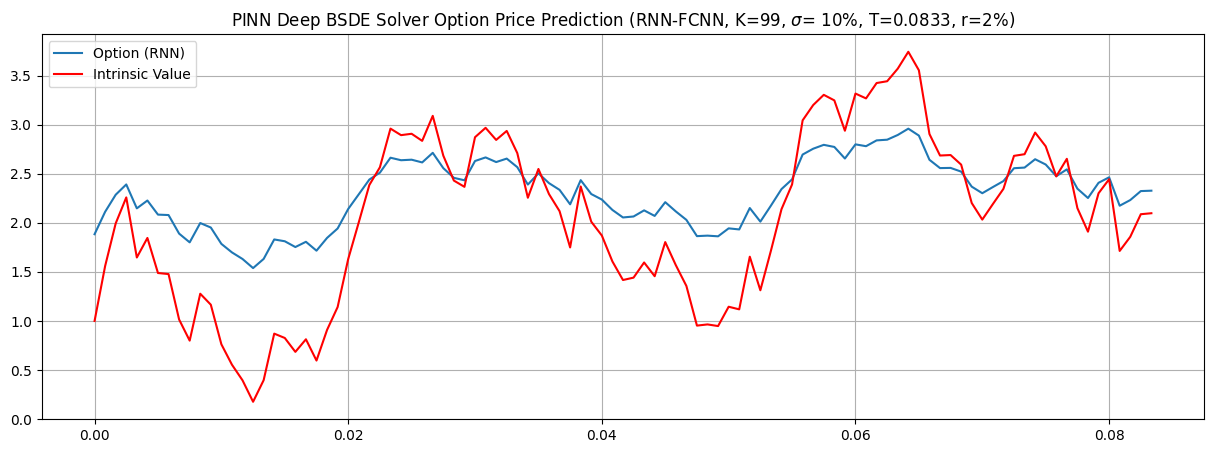

In [605]:
with torch.no_grad():
    Y_RNN, Z_RNN = RNN_FCNN_Net(T_Test, S_Test)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(T_Test.cpu()[0], Y_RNN.cpu()[0], label="Option (RNN)")
ax.plot(T_Test.cpu()[0], torch.relu(S_Test.cpu()[0].mean(-1) - STRIKE), color="red", label="Intrinsic Value")
ax.grid()
ax.legend(loc="upper left")

plt.title(f"PINN Deep BSDE Solver Option Price Prediction (RNN-FCNN, K={STRIKE}, $\sigma$={COV[0][0] ** 0.5 * 100: .0f}%, T={TIME_TO_MATURITY:.4f}, r={RISK_FREE_RATE* 100:.0f}%)")
plt.show()

## Long-Short Term Memory

In [606]:
LSTM_net = BSDE_Net(
    model=BSDE_LSTM,
    model_name=f"BSDE_LSTM_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=25,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=False,
    device=DEVICE
)
print(f"Number of parameters in LSTM part: {LSTM_net.net.num_params}")

Number of parameters in LSTM part: 3164


### Training

#### YNet ZNet LSTM Training PINN-off

In [607]:
if not IS_TRAINED:
    losses = training_bsde_solver(
    model=LSTM_net,
    model_name=LSTM_net.model_name,
    epochs=EPOCHS,
    dwt=dW,
    time_grid=T,
    risk_free_rate=RISK_FREE_RATE,
    cov_matrix=COV,
    price=S,
    payoff_=payoff,
    strike=STRIKE,
    kind=KIND,
    pinn_on=IS_TRAINED,
    lr=1e-2,
    step_size=100,
    gamma=0.1,
    save_params=False
    )
    torch.save(LSTM_net.YNet.state_dict(), f"./params/Best_BSDE_LSTM_YNet_{ASSET_DIM}d.pth")
    torch.save(LSTM_net.ZNet.state_dict(), f"./params/Best_BSDE_LSTM_ZNet_{ASSET_DIM}d.pth")

In [608]:
LSTM_FCNN_Net = BSDE_Net(
    model=BSDE_FCNN,
    model_name=f"BSDE_LSTM_FCNN_{ASSET_DIM}d",
    asset_dim=ASSET_DIM,
    hidden_dim=36,
    latent_dim=LATENT_DIM,
    time_embedding_dim=TIME_EMBEDDING_DIM,
    trained=IS_TRAINED,
    device=DEVICE
)
LSTM_FCNN_Net.YNet.load_state_dict(torch.load(f"./params/Best_BSDE_LSTM_YNet_{ASSET_DIM}d.pth"))
LSTM_FCNN_Net.ZNet.load_state_dict(torch.load(f"./params/Best_BSDE_LSTM_ZNet_{ASSET_DIM}d.pth"))

<All keys matched successfully>

#### PINN - ON

Freeze YNet and ZNet

In [609]:
if not IS_TRAINED:
    for param in LSTM_FCNN_Net.YNet.parameters():
        param.requires_grad_(False)
    for param in LSTM_FCNN_Net.ZNet.parameters():
        param.requires_grad_(False)
    losses = training_bsde_solver(
            model=LSTM_FCNN_Net,
            model_name=LSTM_FCNN_Net.model_name,
            epochs=EPOCHS,
            dwt=dW,
            time_grid=T,
            risk_free_rate=RISK_FREE_RATE,
            cov_matrix=COV,
            price=S,
            payoff_=payoff,
            strike=STRIKE,
            kind=KIND,
            pinn_on=True,
            lr=1e-2,
            step_size=100,
            gamma=0.9,
        min_change=0.001
    )

    torch.save(LSTM_FCNN_Net.YNet.state_dict(), f"./params/Best_BSDE_LSTM_YNet_{ASSET_DIM}d.pth")
    torch.save(LSTM_FCNN_Net.ZNet.state_dict(), f"./params/Best_BSDE_LSTM_ZNet_{ASSET_DIM}d.pth")

### Evaluation

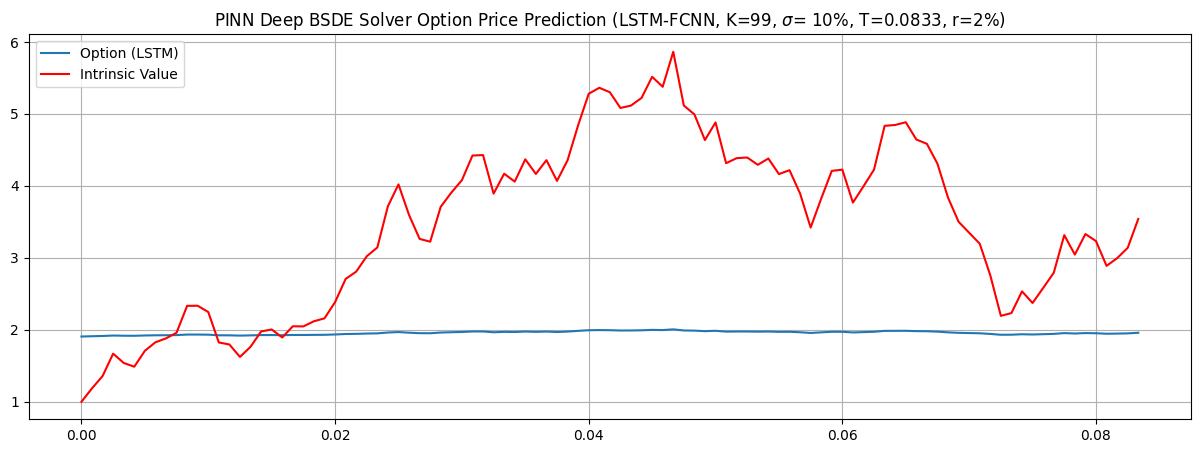

In [610]:
with torch.no_grad():
    Y_LSTM, Z_LSTM = LSTM_FCNN_Net(T_Test, S_Test)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(T_Test.cpu()[0], Y_LSTM.cpu()[1], label="Option (LSTM)")
ax.plot(T_Test.cpu()[0], torch.relu(S_Test.cpu()[1].mean(-1) - STRIKE), color="red", label="Intrinsic Value")
ax.grid()
ax.legend(loc="upper left")

plt.title(f"PINN Deep BSDE Solver Option Price Prediction (LSTM-FCNN, K={STRIKE}, $\sigma$={COV[0][0] ** 0.5 * 100: .0f}%, T={TIME_TO_MATURITY:.4f}, r={RISK_FREE_RATE* 100:.0f}%)")
plt.show()

# Comparison

In [611]:
def bs_european_option(S, K, T, r, sigma, kind='call'):
    """
    Black-Scholes formula for European option pricing (1D)

    Parameters:
    - S: float, current asset price
    - K: float, strike price
    - T: float, time to maturity (in years)
    - r: float, risk-free interest rate
    - sigma: float, volatility (standard deviation of returns)
    - kind: str, 'call' or 'put'

    Returns:
    - option_price: float
    """
    import numpy as np
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if kind == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif kind == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option kind must be 'call' or 'put'")

    return price

def bs_call_delta(S, K, T, r, sigma):
    """
    Calculate Black-Scholes Delta for a European Call Option.

    Args:
        S (torch.Tensor): current asset price(s), shape = (N,) or scalar
        K (float): strike price
        T (float): time to maturity (in years)
        r (float): risk-free rate
        sigma (float): volatility

    Returns:
        torch.Tensor: delta values
    """
    S = torch.tensor(S, dtype=torch.float32)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * torch.sqrt(T))
    normal = torch.distributions.Normal(0, 1)
    delta = normal.cdf(d1)
    return delta

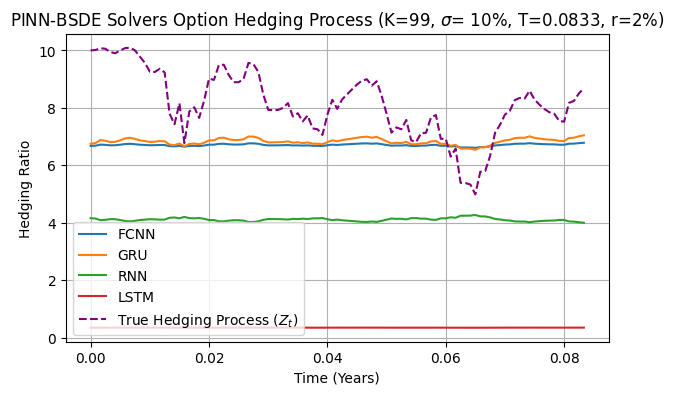

In [639]:
if ASSET_DIM == 1:
    idx = 2
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(T_Test.cpu()[0], Z_FCNN.cpu()[idx], label="FCNN")
    ax.plot(T_Test.cpu()[0], Z_GRU.cpu()[idx], label="GRU")
    ax.plot(T_Test.cpu()[0], Z_RNN.cpu()[idx], label="RNN")
    ax.plot(T_Test.cpu()[0], Z_LSTM.cpu()[idx], label="LSTM")
    ax.plot(
        T_Test.cpu()[0],
        (bs_call_delta(S_Test[idx], STRIKE, T_Test[0], RISK_FREE_RATE, torch.linalg.cholesky(COV)) * S_Test[idx] * torch.linalg.cholesky(COV)).cpu(),
        color="purple", label="True Hedging Process $(Z_t)$", linestyle="--"
    )
    ax.grid()
    ax.legend(loc="best")

    plt.ylabel("Hedging Ratio")
    plt.xlabel("Time (Years)")
    plt.title(f"PINN-BSDE Solvers Option Hedging Process (K={STRIKE}, $\sigma$={COV[0][0] ** 0.5 * 100: .0f}%, T={TIME_TO_MATURITY:.4f}, r={RISK_FREE_RATE* 100:.0f}%)")
    plt.savefig(f"Coursework/My Paper/img/{ASSET_DIM}D ZNet.pdf")
    plt.show()

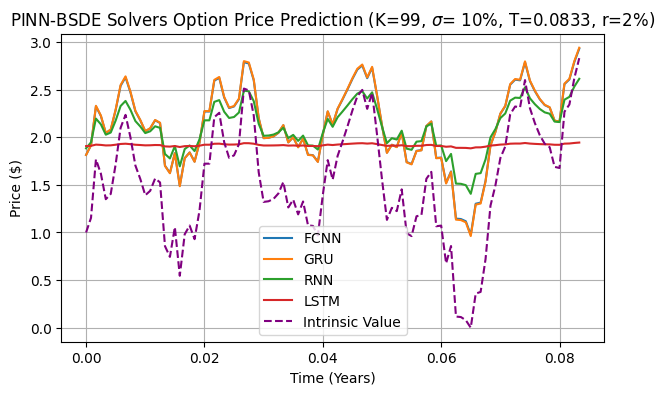

In [638]:
idx = 2 if ASSET_DIM == 1 else 9

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(T_Test.cpu()[0], Y_FCNN.cpu()[idx], label="FCNN")
ax.plot(T_Test.cpu()[0], Y_GRU.cpu()[idx], label="GRU")
ax.plot(T_Test.cpu()[0], Y_RNN.cpu()[idx], label="RNN")
ax.plot(T_Test.cpu()[0], Y_LSTM.cpu()[idx], label="LSTM")
ax.plot(T_Test.cpu()[0], torch.relu(S_Test.cpu()[idx].mean(-1) - STRIKE), color="purple", label="Intrinsic Value", linestyle="--")
ax.grid()
ax.legend(loc="best")

plt.ylabel("Price ($)")
plt.xlabel("Time (Years)")
plt.title(f"PINN-BSDE Solvers Option Price Prediction (K={STRIKE}, $\sigma$={COV[0][0] ** 0.5 * 100: .0f}%, T={TIME_TO_MATURITY:.4f}, r={RISK_FREE_RATE* 100:.0f}%)")
plt.savefig(f"Coursework/My Paper/img/{ASSET_DIM}D PINN Compare.pdf")
plt.show()

In [614]:
torch.manual_seed(42)
_, S_more = random_routes(
    S0_=S0,
    batch_size=10**6,
    time_to_maturity=TIME_TO_MATURITY,
    num_interval=NUM_INTERVAL,
    risk_free_rate=RISK_FREE_RATE,
    covariance=COV,
    device=DEVICE
)

Compare: pandas.DataFrame = pandas.DataFrame(columns=["Price", "Error Rate (%)"])
Compare = pandas.DataFrame({"Price": {
    "BS Model": bs_european_option(S0.to("cpu"), STRIKE, TIME_TO_MATURITY, RISK_FREE_RATE, torch.linalg.cholesky(COV.to("cpu"))).item() if ASSET_DIM == 1 else None,
    "Monte Carlo (N=1M)": monte_carlo_pricing(S_more, RISK_FREE_RATE, TIME_TO_MATURITY, payoff, STRIKE, KIND).item(),
    "Monte Carlo (N=10K)": monte_carlo_pricing(S, RISK_FREE_RATE, TIME_TO_MATURITY, payoff, STRIKE, KIND).item(),
    "FCNN": Y_FCNN[:, 0].mean(0).item(),
    "GRU": Y_GRU[:, 0].mean(0).item(),
    "RNN": Y_RNN[:, 0].mean(0).item(),
    "LSTM": Y_LSTM[:, 0].mean(0).item(),
}})
Compare["Error Rate (%)"] = 100 * Compare["Price"] / Compare["Price"][0 if ASSET_DIM == 1 else 1] - 100
Compare.round(4).style

,Price,Error Rate (%)
BS Model,1.820400,0.000000
Monte Carlo (N=1M),1.848600,1.549800
Monte Carlo (N=10K),1.854400,1.869700
FCNN,1.814200,-0.337400
GRU,1.813700,-0.365100
RNN,1.883600,3.476000
LSTM,1.906800,4.749300
